<a href="https://colab.research.google.com/github/deguc/datascience/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

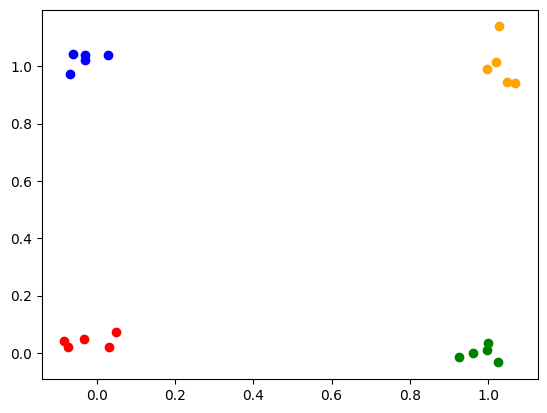

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#マルチレイヤーネットワーク

def DateSets(y=[0,1,1,1],N=50,loc=0,scale=0.05):

  #N=10         データのサイズ
  #loc          平均
  #scale=0.05   標準偏差

  X_=np.array([[0,0],[0,1],[1,0],[1,1]])#学習用データ

  #元のデータにノイズを足す。
  X0=X_[0]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X1=X_[1]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X2=X_[2]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X3=X_[3]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X=np.concatenate((X0,X1,X2,X3))   #データを結合する。

  #正解ラベル
  y0=np.full(N,y[0])
  y1=np.full(N,y[1])
  y2=np.full(N,y[2])
  y3=np.full(N,y[3])
  y=np.concatenate((y0,y1,y2,y3))   #データを結合する

  return X,y

def Plot(X,y):
  #データをプロットする。
  n=y.max()
  c=['red','blue','green','orange']
  for k in range(n+1):
    plt.scatter(X[y==k,0],X[y==k,1],c=c[k]);



X,y=DateSets(y=[0,1,2,3],N=5)

Plot(X,y)
plt.show()




In [ ]:
#ディープラーニングへの拡張を意識したコーディング

import numpy as np

class Perceptron:

  def __init__(self):

    #コンストラクタ

    self.W=np.random.randn(2,1)   #重みの初期化
    self.b=0      #バイアスの初期化

    self.X=None   #入力データの保存

  def forward(self,X):

    #順伝播

    a=np.matmul(X,self.W)+self.b  #アフィン変換

    self.X=X  #入力データを保存

    y=(a>0)*1 #ステップ関数

    return y

  def backward(self,delta):

    #逆伝播

    #勾配を計算
    dW=np.matmul(self.X.T,delta)
    db=np.sum(delta,axis=0)

    #重みとバイアスの更新
    self.W-=0.1*dW
    self.b-=0.1*db
    return None

  def fit(self,X,t,epochs=100):

    #学習

    for __ in range(epochs):
      y=self.forward(X)   #予測
      delta=y-t           #誤差
      self.backward(delta)  #重みとバイアスを更新

    return None

  def __call__(self,X):

    #予測

    y=self.forward(X)

    return y.flatten()  #(n,1)　→ (n, )


X=np.array([[0,0],[0,1],[1,0],[1,1]])   #入力データ
y=np.array([0,1,1,1])     #教師データ

t=y.reshape(-1,1)   #学習用にデータの前処理

model=Perceptron()    #インスタンス化

model.fit(X,t)    #学習

pred=model(X)   #学習結果の確認

print(pred)

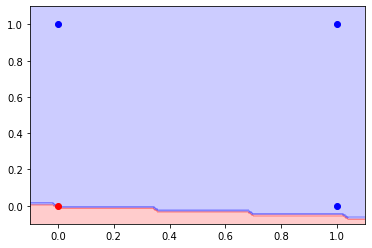

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def decision_regions(x,y,model):

  #平面を分割する。

  #グリッドの作成
  x1=np.arange(-0.1,1.1,0.02)   #横軸
  x2=np.arange(-0.1,1.1,0.02)   #縦軸
  xx1,xx2=np.meshgrid(x1,x2)    #メッシュ
  z=np.array([xx1.ravel(),xx2.ravel()]).T   #座標点の作成


  Z=model(z).reshape(xx1.shape)   #各座標点を分類する

  plt.contourf(xx1,xx2,Z,alpha=0.2,cmap=ListedColormap(['red','blue'])) #平面の分割

  #データをプロットする。
  plt.scatter(x[y==0,0],x[y==0,1],c='red')
  plt.scatter(x[y==1,0],x[y==1,1],c='blue')

#動作の確認
decision_regions(X,y,model)


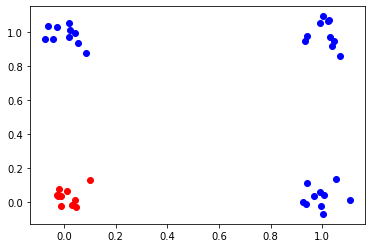

In [ ]:
#分散したデータの作成

N=10      #データのサイズ
scale=0.05  #データのちらし方

X_train=np.array([[0,0],[0,1],[1,0],[1,1]])#学習用データ

#元のデータにノイズを足す。
X1=X[0]+np.random.randn(N,2)*scale
X2=X[1]+np.random.randn(N,2)*scale
X3=X[2]+np.random.randn(N,2)*scale
X4=X[3]+np.random.randn(N,2)*scale

X_test=np.concatenate((X1,X2,X3,X4))   #データを結合する。

#動作の確認
y_train=np.array([0,1,1,1])   #教師用データ
t_train=y_train.reshape(-1,1)     #前処理

#教師データで学習
model=Perceptron()
model.fit(X_train,t_train,epochs=30)

y_test=model(X_test)

plt.scatter(X_test[y_test==0,0],X_test[y_test==0,1],c='red')
plt.scatter(X_test[y_test==1,0],X_test[y_test==1,1],c='blue')

plt.show()